## Imports and install

In [1]:
# Installing yfinance package
!pip install yfinance -q

     |████████████████████████████████| 6.4 MB 17.0 MB/s 


In [2]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler

## Utility functions

In [3]:
def create_train_set(train_data, past):
    n = train_data.shape[0]
    x = np.zeros((n-past, past, 1))
    y = np.zeros((n-past,))
    for i in range(past, n):
        temp = 0
        for j in range(i-past, i):
            x[i-past, temp, 0] = train_data[j, 0]
            temp += 1
        y[i-past] = train_data[i, 0]
    return x, y

def create_val_set(val_data, train_data, past):
    n = val_data.shape[0]
    n_train = train_data.shape[0]
    temp_set = np.concatenate((train_data[n_train-past:], val_data))
    x = np.zeros((n, past, 1))
    y = np.zeros((n,))
    for i in range(n):
        temp = 0
        for j in range(i, i+past):
            x[i, temp, 0] = temp_set[j, 0]
            temp += 1
        y[i] = temp_set[i+past, 0]
    return x, y

In [4]:
def plot_results(title, loss, val_loss):
  fig, (ax1) = plt.subplots(1, 1)
  fig.tight_layout(pad=4)
  fig.suptitle(title)
  ax1.set_title('Loss')
  ax1.plot(loss)
  ax1.plot(val_loss)
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoch')
  ax1.legend(['training', 'validation'], loc='upper right')
  fig.show()

In [5]:
def plot_predictions(model, scaler, x_norm, y_norm, title):
    y_predict_norm = model.predict(x_norm)
    y_predict_true = np.squeeze(scaler.inverse_transform(y_predict_norm))
    y_true = np.squeeze(scaler.inverse_transform([y_norm]))
    plt.plot(y_predict_true)
    plt.plot(y_true)
    plt.title(title)
    plt.ylabel('Price')
    plt.legend (["Predictions", "True values"])
    plt.show()

## Model

In [6]:
def model_factory(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(units=50, return_sequences=True)(inputs)
    x = Dropout(rate=0.2)(x)
    x = LSTM(units=50, return_sequences=True)(x)
    x = Dropout(rate=0.2)(x)
    x = LSTM(units=50, return_sequences=True)(x)
    x = Dropout(rate=0.2)(x)
    x = LSTM(units=50, return_sequences=False)(x)
    outputs = Dense(units=1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(),
    )
    return model

## Loading dataset

In [7]:
# Loading dataset
train_data = yf.download("BTC-USD", start="2014-01-01", end="2021-09-01")
val_data = yf.download("BTC-USD", start="2021-09-02")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
# Showing first 10 days
train_data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600
2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500
2014-09-24,435.751007,436.112000,421.131989,423.204987,423.204987,30627700
2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400


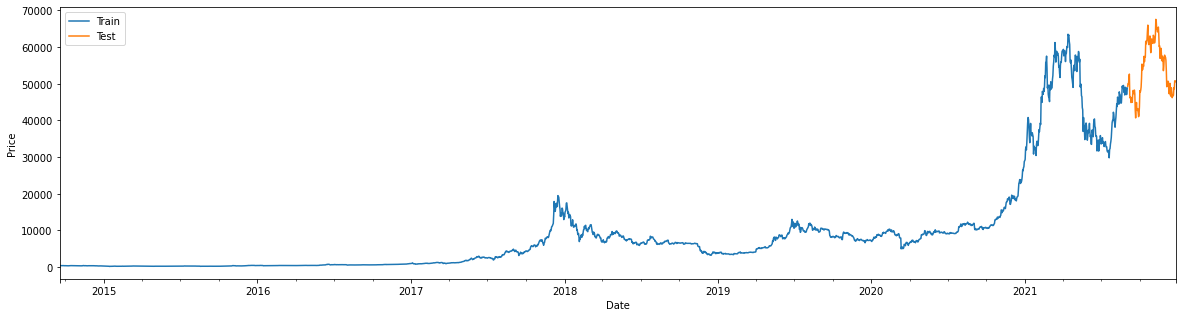

In [9]:
# Plot train and test time series
plt.figure(figsize=(20, 5))
train_data.Close.plot()
val_data.Close.plot()
plt.ylabel('Price')
plt.legend (["Train", "Test"])
plt.show()

In [10]:
train_data = train_data.Close.values.reshape(-1, 1)
val_data = val_data.Close.values.reshape(-1, 1)

In [11]:
# Normalize close values
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.fit_transform(train_data)
val_data = scaler.fit_transform(val_data)

In [12]:
print("Train shape:", train_data.shape)
print("Val shape:", val_data.shape)

Train shape: (2542, 1)
Val shape: (115, 1)


## Hyperparms

In [13]:
FUTURE = 3*30
BATCH_SIZE = 32
EPOCHS = 100

## Past = 60

In [14]:
PAST = 60

In [15]:
x_train, y_train = create_train_set(train_data, PAST)
x_val, y_val = create_val_set(val_data, train_data, PAST)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (2482, 60, 1)
y_train shape: (2482,)
x_val shape: (115, 60, 1)
y_val shape: (115,)


In [16]:
input_shape = (PAST, 1)
model = model_factory(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0     

In [17]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/100
78/78 [==============================] - 22s 113ms/step - loss: 0.0047 - val_loss: 0.0648
Epoch 2/100
78/78 [==============================] - 5s 69ms/step - loss: 0.0017 - val_loss: 0.0578
Epoch 3/100
78/78 [==============================] - 5s 68ms/step - loss: 0.0015 - val_loss: 0.0537
Epoch 4/100
78/78 [==============================] - 5s 67ms/step - loss: 0.0012 - val_loss: 0.0423
Epoch 5/100
78/78 [==============================] - 5s 65ms/step - loss: 0.0012 - val_loss: 0.0520
Epoch 6/100
78/78 [==============================] - 5s 63ms/step - loss: 0.0011 - val_loss: 0.0508
Epoch 7/100
78/78 [==============================] - 5s 63ms/step - loss: 9.1505e-04 - val_loss: 0.0418
Epoch 8/100
78/78 [==============================] - 5s 63ms/step - loss: 9.0282e-04 - val_loss: 0.0320
Epoch 9/100
78/78 [==============================] - 5s 63ms/step - loss: 7.6257e-04 - val_loss: 0.0314
Epoch 10/100
78/78 [==============================] - 5s 63ms/step - loss: 9.0425e-04 

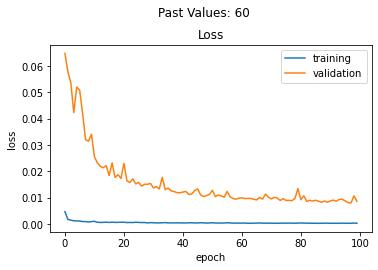

In [18]:
plot_results(
    title=f"Past Values: {PAST}",
    loss=history.history["loss"],
    val_loss=history.history["val_loss"],
)

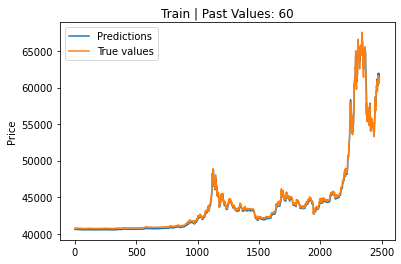

In [19]:
# Train predictions
plot_predictions(
    model,
    scaler,
    x_train,
    y_train,
    title=f"Train | Past Values: {PAST}"
)

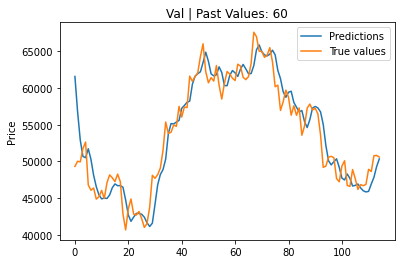

In [20]:
# Test predictions
plot_predictions(
    model,
    scaler,
    x_val,
    y_val,
    title=f"Val | Past Values: {PAST}"
)

In [21]:
n_val = val_data.shape[0]
test_data = np.concatenate((val_data[n_val-PAST:], np.zeros((FUTURE, 1))))

for i in range(PAST, FUTURE + PAST):
    batch = test_data[i-PAST:i].T
    batch = np.expand_dims(batch, axis=2)
    prediction = model.predict(batch)
    test_data[i] = np.squeeze(prediction)

test_data = scaler.inverse_transform(test_data)
past_prices = test_data[:PAST]
future_prices = test_data[PAST+1:]

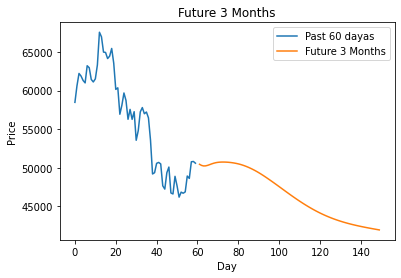

In [22]:
plt.plot(range(0, PAST), past_prices)
plt.plot(range(PAST+1, PAST+FUTURE), future_prices)
plt.title("Future 3 Months")
plt.xlabel("Day")
plt.ylabel('Price')
plt.legend (["Past 60 dayas", "Future 3 Months"])
plt.show()

## Past = 90

In [23]:
PAST = 90

In [24]:
x_train, y_train = create_train_set(train_data, PAST)
x_val, y_val = create_val_set(val_data, train_data, PAST)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (2452, 90, 1)
y_train shape: (2452,)
x_val shape: (115, 90, 1)
y_val shape: (115,)


In [25]:
input_shape = (PAST, 1)
model = model_factory(input_shape)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 90, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 90, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 90, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 90, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 90, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 90, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 90, 50)            0   

In [26]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/100
77/77 [==============================] - 15s 107ms/step - loss: 0.0045 - val_loss: 0.0844
Epoch 2/100
77/77 [==============================] - 7s 86ms/step - loss: 0.0019 - val_loss: 0.0665
Epoch 3/100
77/77 [==============================] - 7s 87ms/step - loss: 0.0012 - val_loss: 0.0539
Epoch 4/100
77/77 [==============================] - 7s 86ms/step - loss: 0.0014 - val_loss: 0.0419
Epoch 5/100
77/77 [==============================] - 7s 86ms/step - loss: 0.0013 - val_loss: 0.0433
Epoch 6/100
77/77 [==============================] - 7s 87ms/step - loss: 9.5916e-04 - val_loss: 0.0464
Epoch 7/100
77/77 [==============================] - 7s 86ms/step - loss: 0.0010 - val_loss: 0.0442
Epoch 8/100
77/77 [==============================] - 7s 86ms/step - loss: 8.7150e-04 - val_loss: 0.0300
Epoch 9/100
77/77 [==============================] - 7s 86ms/step - loss: 8.1027e-04 - val_loss: 0.0295
Epoch 10/100
77/77 [==============================] - 7s 86ms/step - loss: 7.4029e-04 

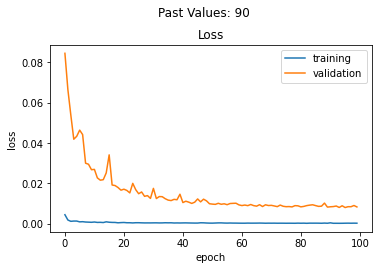

In [27]:
plot_results(
    title=f"Past Values: {PAST}",
    loss=history.history["loss"],
    val_loss=history.history["val_loss"],
)

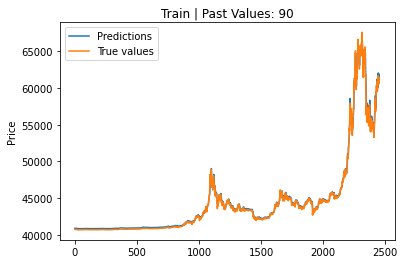

In [28]:
# Train predictions
plot_predictions(
    model,
    scaler,
    x_train,
    y_train,
    title=f"Train | Past Values: {PAST}"
)

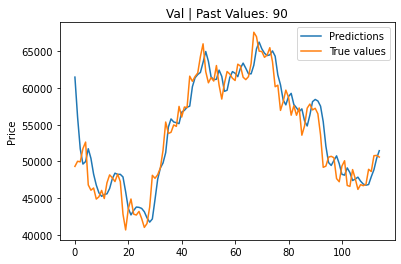

In [29]:
# Test predictions
plot_predictions(
    model,
    scaler,
    x_val,
    y_val,
    title=f"Val | Past Values: {PAST}"
)

In [30]:
n_val = val_data.shape[0]
test_data = np.concatenate((val_data[n_val-PAST:], np.zeros((FUTURE, 1))))

for i in range(PAST, FUTURE + PAST):
    batch = test_data[i-PAST:i].T
    batch = np.expand_dims(batch, axis=2)
    prediction = model.predict(batch)
    test_data[i] = np.squeeze(prediction)

test_data = scaler.inverse_transform(test_data)
past_prices = test_data[:PAST]
future_prices = test_data[PAST+1:]

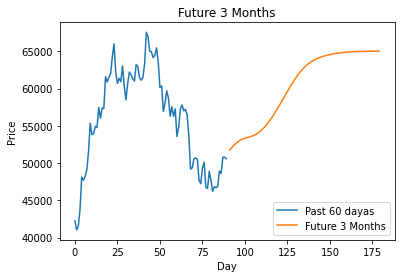

In [31]:
plt.plot(range(0, PAST), past_prices)
plt.plot(range(PAST+1, PAST+FUTURE), future_prices)
plt.title("Future 3 Months")
plt.xlabel("Day")
plt.ylabel('Price')
plt.legend (["Past 60 dayas", "Future 3 Months"])
plt.show()